In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.func import jacrev
import pickle

In [12]:
plt.style.use('/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/style_full_notex.mplstyle')

device = "cpu"

In [28]:
distribution = "angularity"
order_to_match = 2
name = "test"
init = "init_random"
outfile_name = f"{distribution}_{order_to_match}_{name}_{init}"

mstar = 1


In [14]:
# load in data

with open(f"data/{outfile_name}", "rb") as ifile:
    save_dict = pickle.load(ifile)

losses = save_dict["loss"]
g_coeffs_log = save_dict["g_coeffs"]

In [15]:
# Helper functions ofr plotting

max_M, max_N = g_coeffs_log[0].shape


factorial_cache_n = torch.tensor([math.factorial(k) for k in range(max_N)], device=device).float()
factorial_cache_m = torch.tensor([math.factorial(k) for k in range(max_M)], device=device).float()
n_range = torch.arange(max_N, device=device)
m_range = torch.arange(1, max_M, device=device)

N_integrator = 250

def f(t, alpha, g_coeffs, mstar):
    t_powers = (t[..., None] ** n_range) / factorial_cache_n
    g_star = alpha ** mstar * torch.abs(torch.sum(g_coeffs[0] * t_powers, dim=-1))
    t_powers_exp = t_powers.unsqueeze(-2)
    g_coeffs_higher = g_coeffs[1:] / factorial_cache_m[1:, None]
    g_higher_mat = torch.sum(g_coeffs_higher * t_powers_exp, dim=-1)
    g_higher = torch.sum((alpha ** (mstar + m_range)) * g_higher_mat, dim=-1)
    return g_star * torch.exp(-g_higher)

def cumulative_trapezoidal(alpha, g_coeffs, mstar, t_grid):
    f_vals = f(t_grid, alpha, g_coeffs, mstar)
    dt = t_grid[1] - t_grid[0]
    cum = torch.cumsum((f_vals[:-1] + f_vals[1:]) * 0.5 * dt, dim=0)
    cum = torch.cat([torch.zeros(1, device=device), cum])
    return cum


def q(t, alpha, g_coeffs, mstar):


    t_dense = torch.linspace(0.0, xlim, N_integrator, device=device)
    F_dense = cumulative_trapezoidal(alpha, g_coeffs, mstar, t_dense)

    # Interpolate
    epsilon_regularization = 1e-12
    idx = torch.searchsorted(t_dense, t.clamp(max=t_dense[-1]), right=True) - 1
    idx = idx.clamp(min=0, max=t_dense.shape[0] - 2)
    t0, t1 = t_dense[idx], t_dense[idx + 1]
    F0, F1 = F_dense[idx], F_dense[idx + 1]
    exp_term = F0 + (F1 - F0) * (t - t0) / (t1 - t0 + epsilon_regularization)
    return f(t, alpha, g_coeffs, mstar) * torch.exp(-exp_term)



In [17]:

    
nbins = 80

if distribution == "exponential":
    xlim = 20
else:
    xlim = 15

t_bins = torch.linspace(0, xlim, nbins, device=device)
t_bin_centers = 0.5 * (t_bins[1:] + t_bins[:-1])

def get_pdf(alpha, *, example="exponential", order=1):
    alpha = torch.as_tensor(alpha, device=device)[..., None]
    if example == "exponential":
        if order == -1:
            y = alpha * torch.exp(-alpha * t_bin_centers)
        elif order == 1:
            y = alpha.expand_as(alpha * t_bin_centers) * 0 + alpha 
        elif order == 2:
            y = alpha * (1 - alpha * t_bin_centers)
    elif example == "angularity":
        if order == -1:
            y = alpha * t_bin_centers * torch.exp(-alpha * t_bin_centers**2 / 2)
        elif order == 1:
            y = alpha * t_bin_centers
        elif order == 2:
            y = alpha * t_bin_centers * (1 - alpha * t_bin_centers**2 / 2)
    else:
        raise ValueError("bad example/order")
    #y[y < 0] = 0
    return y.squeeze(0)



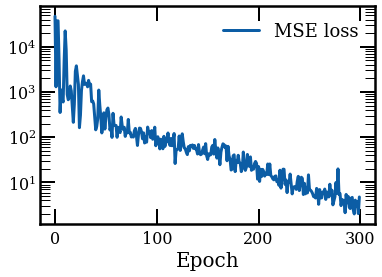

In [21]:


# Plot loss
plt.figure()
plt.plot(losses, label="MSE loss")
plt.legend()
plt.yscale("log")
plt.xlabel("Epoch")
plt.savefig(f"plots/{outfile_name}_loss.png")
plt.show()



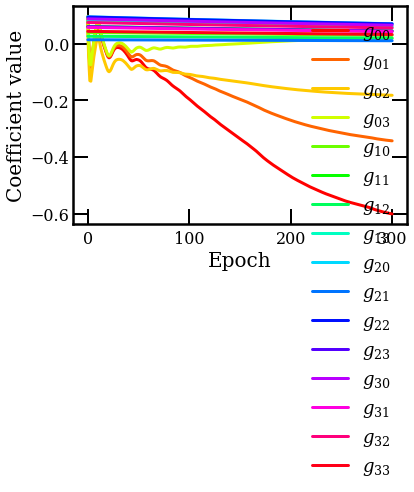

In [22]:


from matplotlib.pyplot import cm
color = iter(cm.hsv(np.linspace(0, 1, g_coeffs_log.shape[1]*g_coeffs_log.shape[2])))

plt.figure()
for m in range(g_coeffs_log.shape[1]):
    for n in range(g_coeffs_log.shape[2]):
        c = next(color)
        label = f"$g_{{{m}{n}}}$"
        plt.plot(g_coeffs_log[:, m, n], label=label, color=c)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Coefficient value")
plt.show()



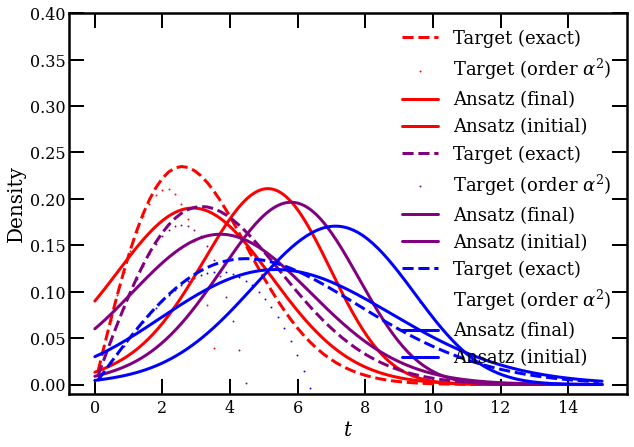

In [36]:


tt = torch.linspace(0, xlim, 200, device=device)
colors = ["red", "purple", "blue"]


plt.figure(figsize = (10, 7))
for i, alpha in enumerate([0.15, 0.1, 0.05]):
    alpha_tensor = torch.tensor(alpha, device=device)
    plt.plot( t_bin_centers.detach().cpu().numpy(),  get_pdf(alpha_tensor, example=distribution, order=-1).detach().cpu().numpy(), label="Target (exact)",  color=colors[i],  linestyle="dashed" )
    plt.scatter(  t_bin_centers.detach().cpu().numpy(), get_pdf(alpha_tensor, example=distribution, order=order_to_match).detach().cpu().numpy(), label=f"Target (order $\\alpha^{order_to_match}$)", color=colors[i], s=0.8)
    plt.plot(tt.detach().cpu().numpy(), q(tt, alpha_tensor, torch.tensor(g_coeffs_log[-1]), mstar).detach().cpu().numpy(), label="Ansatz (final)", color=colors[i])
    plt.plot(tt.detach().cpu().numpy(), q(tt, alpha_tensor, torch.tensor(g_coeffs_log[0]), mstar).detach().cpu().numpy(), label="Ansatz (initial)", color=colors[i])


plt.legend()
plt.xlabel("$t$")
plt.ylabel("Density")
plt.ylim(-0.01, 0.4)
plt.show()